# Simple binary classifier
### With stopwords and doubled vocab size
This notebook shows a simple model inspired by the Tensorflow tutorial, using the datasets containing stopwords.

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()

## Dataset
Load datasets

In [2]:
def load_data_arrays():
  df_1 = pd.read_csv("../../datasets/1_preprocessed.csv")
  df_3 = pd.read_csv("../../datasets/3_preprocessed.csv")
  df_5 = pd.read_csv("../../datasets/5_preprocessed.csv")
  df_6 = pd.read_csv("../../datasets/6_preprocessed.csv")

  df = df_1.append(df_3)
  df = df.append(df_5)
  df = df.append(df_6)

  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])

  return train_df, test_df

train_df, test_df = load_data_arrays()

Convert train and test datasets to Tensorflow datasets

In [3]:
train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
  tf.data.Dataset.from_tensor_slices(
    (
      tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
      tf.cast(train_labels, tf.int32)
    )
  )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
  tf.data.Dataset.from_tensor_slices(
    (
      tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
      tf.cast(test_labels, tf.int32)
    )
  )
)

Shuffle training data and create batches of (text, label) pairs

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model
### Create the text encoder
We create a text encoder using text vectorization. We define a vocabulary size of 1000 words and let Tensorflow create the vocabulary for this layer by adapting it to our dataset.

In [5]:
VOCAB_SIZE = 2000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

## Create the model
We create a RNN model with different layers and let them process sequentially (because we have single input and output). At first, we create a numerical representation of the text using our encoder, which is transformed to an embedding. We then dense the output in 2 steps.

In [6]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 202,434
Trainable params: 202,434
Non-trai

### Compile the model
For the loss function we use binary cross entropy, since we have a binary classifier. We use a little learning rate of 0.01% in this first model, because it gives some good results.

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

### Train the model
We train the compiled model in 5 epochs. More epochs are not necessary because of decreasing improvements.

In [8]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
2717/2717 [==============================] - 262s 94ms/step - loss: 0.2560 - accuracy: 0.8965 - val_loss: 0.2175 - val_accuracy: 0.9203
Epoch 2/5
2717/2717 [==============================] - 252s 93ms/step - loss: 0.1743 - accuracy: 0.9332 - val_loss: 0.2086 - val_accuracy: 0.9172
Epoch 3/5
2717/2717 [==============================] - 270s 99ms/step - loss: 0.1689 - accuracy: 0.9343 - val_loss: 0.2099 - val_accuracy: 0.9187
Epoch 4/5
2717/2717 [==============================] - 275s 101ms/step - loss: 0.1662 - accuracy: 0.9351 - val_loss: 0.2061 - val_accuracy: 0.9094
Epoch 5/5
2717/2717 [==============================] - 290s 107ms/step - loss: 0.1641 - accuracy: 0.9352 - val_loss: 0.2104 - val_accuracy: 0.9172


### Test the model
We use our test dataset to verify the accuracy of our model.

In [9]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

680/680 [==============================] - 24s 35ms/step - loss: 0.1903 - accuracy: 0.9266
Test Loss: 0.19030322134494781
Test Accuracy: 0.9265548586845398


Plot the results

(0.0, 0.2606387257575989)

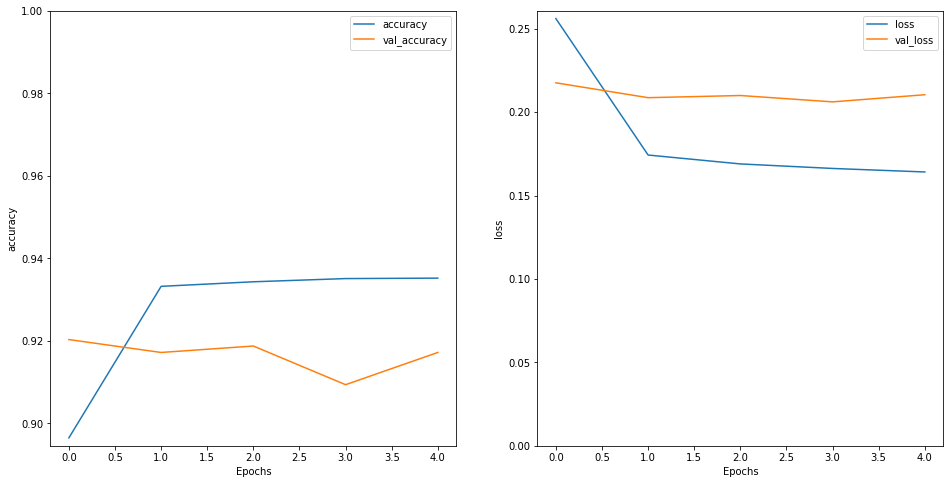

In [10]:
np.set_printoptions(precision=3, suppress=True)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

               precision    recall  f1-score   support

no hatespeech       0.94      0.97      0.95     31026
   hatespeech       0.92      0.83      0.88     12435

     accuracy                           0.93     43461
    macro avg       0.93      0.90      0.91     43461
 weighted avg       0.93      0.93      0.93     43461



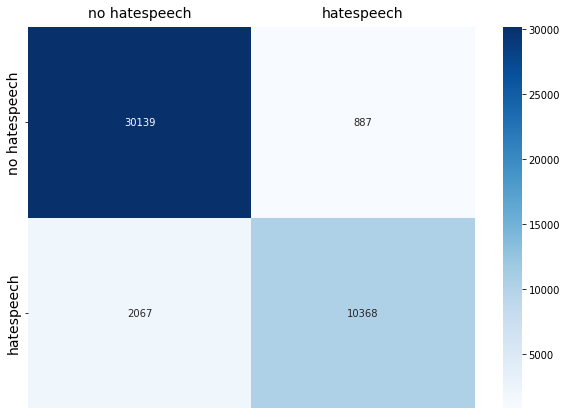

In [11]:
from sklearn.metrics import classification_report
import seaborn as sn

pred = model.predict(test_dataset)
test_data_labels = np.concatenate([y for x, y in test_dataset], axis=0)

print(classification_report(test_data_labels.argmax(axis=1),
                            pred.argmax(axis=1),
                            target_names=['no hatespeech', 'hatespeech']))

def plot_confusion_matrix(labels, pred, index, columns):
    conf = tf.math.confusion_matrix(labels=[np.argmax(val) for val in labels],
                                    predictions=[np.argmax(val) for val in pred])

    df_cm = pd.DataFrame(conf.numpy(), index=index, columns=columns)

    plt.figure(figsize=(10, 7))
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom=False, top=False,
                    labeltop=True)
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()

plot_confusion_matrix(labels=test_data_labels,
                      pred=pred,
                      index=['no hatespeech', 'hatespeech'],
                      columns=['no hatespeech', 'hatespeech'])

Do a prediction to exemplary check the model. Results have the format [<probability_no_hate_speech>,<probability_hate_speech>]

In [12]:
sample_text = ['That was very nice of you to say', 'You stupid fucking bitch']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.999 0.001]
 [0.    1.   ]]


(Optional) Save the model for further usage

In [13]:
# model.save('saves/rnn_one', save_format='tf')